In [1]:
class Box:
    def __init__(self,position = (None,None), value=0):
        self.value = value
        self.position = position
        self.domain = set(range(1,10))
        self.pre_filled = False
    def __str__(self):
        return f"Box(Position={self.position}, Value={self.value}, Domain={self.domain})"

In [2]:
class Board:
    def __init__(self):
        self.grid = [[Box((i,j))for j in range(9)] for i in range(9)]
        self.num_backtrack = 0

    def display_boxes(self):
        for row in self.grid:
            for box in row:
                print(box)

    def __str__(self):
        board = ""
        for row in self.grid:
            for box in row:
                board += f"{box.value} "
            board += "\n"
        return board.strip()

    def load_from_string(self,puzzle_string):
        row = 0
        col = 0
        for num in puzzle_string:
            if num == ".":
                self.grid[row][col].value = 0
            else:
                self.grid[row][col].value = int(num)
                self.grid[row][col].pre_filled = True
            if col == 8:
                row +=1
            col = (col + 1) % 9


    def find_domains_global(self):
        for row in self.grid:
            for box in row:
                value = box.value
                if value != 0:
                    box.domain = set()
                    position = box.position
                    # Clear value in row
                    for i in range(9):
                        self.grid[position[0]][i].domain.discard(value)
                    # ## Clear value in column
                        self.grid[i][position[1]].domain.discard(value)
                    # ## Clear value in 3x3 square
                    start_row = position[0] // 3
                    start_col = position[1] // 3
                    for i in range(3):
                        for j in range(3):
                            self.grid[i+start_row*3][j+start_col*3].domain.discard(value)

    def check_if_valid_assignment(self,position,value):
        # Check for value in same row and col as position
        for i in range(9):
            if self.grid[position[0]][i].value == value or self.grid[i][position[1]].value == value:
                return False
        # Check for value in the same 3x3 subgrid as position
        start_row = position[0] // 3
        start_col = position[1] // 3
        for i in range(3):
            for j in range(3):
                if self.grid[i+start_row*3][j+start_col*3].value == value:
                    return False
        return True

    def find_empty(self):
      # Return the next unfilled position on the board
        for row in self.grid:
            for box in row:
                if box.value == 0:
                    return box.position
        return None

    def forward_checking(self,position,value):
        # Remove value from the domain of boxes in the same row and column as position
        for i in range(9):
            self.grid[position[0]][i].domain.discard(value)
            self.grid[i][position[1]].domain.discard(value)
        # Remove value from the domain of boxes in the same 3x3 subgrid as position
        start_row = position[0] // 3
        start_col = position[1] // 3
        for i in range(3):
            for j in range(3):
                self.grid[i+start_row*3][j+start_col*3].domain.discard(value)


    def domain_checking(self):
      # Check to see if any of the domains in the grid is empty
        for row in self.grid:
          for box in row:
            if box.value == 0 and len(box.domain) == 0:
              return False
        return True


    def restore_domains(self):
        for row in self.grid:
          for box in row:
            box.domain = set(range(1,10))
        self.find_domains_global()


    def find_minimum_remaining_value_box(self):
       # find the box in the grid with the smallest domain
        min_domain_size = float("inf")
        min_box = None

        for i in range(9):
            for j in range(9):
                box = self.grid[i][j]
                if len(box.domain) <= min_domain_size and box.value == 0:
                    min_domain_size = len(box.domain)
                    min_box = box.position

        return min_box
    
    def count_constraints(self,position,value):
        # return the count of how many constraints putting value at postion would impose
        count = 0
        for i in range(9):
          if value in self.grid[position[0]][i].domain:
            count+=1
          if value in self.grid[i][position[1]].domain:
            count+=1

        start_row = position[0] // 3
        start_col = position[1] // 3
        for i in range(3):
            for j in range(3):
                if value in self.grid[i+start_row*3][j+start_col*3].domain:
                  count +=1
        return count

    def order_domain_values(self,domain,position):
        # order the domain in accending order by how many constraints the value in domain imposes
        ordered_domain = sorted(domain, key=lambda value: self.count_constraints(position, value))
        return ordered_domain


    def get_neighbors(self, position):
        # get the neighbors of the box at position
        row, col = position
        neighbors = set()

        for i in range(9):
            if i != col:
                neighbors.add((row, i))
            if i != row:
                neighbors.add((i, col))

        subgrid_row = (row // 3) * 3
        subgrid_col = (col // 3) * 3
        for i in range(subgrid_row, subgrid_row + 3):
            for j in range(subgrid_col, subgrid_col + 3):
                if (i, j) != (row, col):
                    neighbors.add((i, j))

        return neighbors


    def remove_inconsistent_value(self, pair):
        removed = False
        values_to_remove = []
        box_1 = self.grid[pair[0][0]][pair[0][1]]
        box_2 = self.grid[pair[1][0]][pair[1][1]]
        ## for every value in box 1 check if there is a value in box 2 that can satisfy the contraints, if not remove the value from the domain of box 1
        for value in list(box_1.domain):  
            if len(box_2.domain) == 1 and value in box_2.domain:
                box_1.domain.discard(value)
                removed = True
        return removed


    def arc_consistency(self):
        queue = []

        #find all nodes in the board and who thier neighbors are 
        # Put all the pairs in a queqe
        for row in self.grid:
            for box in row:
                neighbors = self.get_neighbors(box.position)
                for neighbor in neighbors:
                    queue.append((box.position, neighbor))
        
        while queue:
            current_pair = queue.pop(0)
            if self.remove_inconsistent_value(current_pair):
                for neighbor in self.get_neighbors(current_pair[0]):
                    queue.append((neighbor, current_pair[0]))


In [3]:
class sudoku_solver:
  def __init__(self,mrv,lcv,forward_checking,arc_consistency):
    self.mrv = mrv
    self.lcv = lcv
    self.forward_checking = forward_checking
    self.arc_consistency = arc_consistency
    assert (self.forward_checking ^ self.arc_consistency) or (self.forward_checking == False and self.arc_consistency == False)

  def backtracking_solve(self,board):
    if self.mrv:
      position = board.find_minimum_remaining_value_box()
    else:
      position = board.find_empty()
    if position == None:
      return True
    box = board.grid[position[0]][position[1]]
    if self.forward_checking or self.arc_consistency or self.lcv:
      domain = board.grid[position[0]][position[1]].domain
      if self.lcv:
        domain = board.order_domain_values(domain,position)
    else:
      domain = set(range(1,10))

    for value in list(domain):
      if board.check_if_valid_assignment(position,value):
        box.value = value
        if self.forward_checking:
          board.forward_checking(position,value)
        elif self.arc_consistency:
          board.arc_consistency()
        if self.arc_consistency or self.forward_checking:
          if board.domain_checking() and self.backtracking_solve(board):
            return True
          box.value = 0
          board.restore_domains()
          board.num_backtrack +=1
        else:
          if self.backtracking_solve(board):
            return True
          box.value = 0
          board.num_backtrack +=1

    return False

  def board_loader(self,string,board):
      board.load_from_string(string)
      if self.forward_checking or self.arc_consistency or self.lcv:
        board.find_domains_global()
      if self.arc_consistency:
        board.arc_consistency()

  def return_stats(self,string):
    board = Board()
    self.board_loader(string,board)
    start_time = time.time()
    self.backtracking_solve(board)
    end_time = time.time()
    time_taken = end_time - start_time
    num_backtracks = board.num_backtrack
    return time_taken, num_backtracks
    
          



In [8]:
import pandas as pd
import time
import numpy as np
df = pd.read_csv("sudoku-3m.csv", nrows=1000)

In [30]:
soduko_board = Board()
solver = sudoku_solver(mrv=False,arc_consistency=False,lcv=False,forward_checking=True)
soduko_board.load_from_string(".75.....34......1....672.....9..16.....3....5.2.56...49.7.4......38.9............")
print(soduko_board)
start_time = time.time()
solver.backtracking_solve(soduko_board)
end_time = time.time()
print()
print(soduko_board)
time_taken = end_time - start_time
print(f"\nTime taken to solve: {time_taken:.4f} seconds")
print(f"\nNumber of backtracking taken to solve: {soduko_board.num_backtrack}")

0 7 5 0 0 0 0 0 3 
4 0 0 0 0 0 0 1 0 
0 0 0 6 7 2 0 0 0 
0 0 9 0 0 1 6 0 0 
0 0 0 3 0 0 0 0 5 
0 2 0 5 6 0 0 0 4 
9 0 7 0 4 0 0 0 0 
0 0 3 8 0 9 0 0 0 
0 0 0 0 0 0 0 0 0

2 7 5 1 8 4 9 6 3 
4 8 6 9 3 5 7 1 2 
3 9 1 6 7 2 5 4 8 
5 3 9 4 2 1 6 8 7 
7 6 4 3 9 8 1 2 5 
1 2 8 5 6 7 3 9 4 
9 1 7 2 4 3 8 5 6 
6 4 3 8 5 9 2 7 1 
8 5 2 7 1 6 4 3 9

Time taken to solve: 0.0796 seconds

Number of backtracking taken to solve: 220


In [10]:
solver = sudoku_solver(mrv=True,arc_consistency=True,lcv=True,forward_checking=False)
time_result = np.zeros((len(df["puzzle"]),1))
num_backtracks = np.zeros((len(df["puzzle"]),1))
count = 0 
for row in df["puzzle"]:
  time_result[count],num_backtracks[count] = solver.return_stats(row)
  if count % 10 == 0:
    print(count)
  count+=1
df["backtracking_w/MRV_w/LCV_w/AC3_time"] = time_result
df["backtracking_w/MRV_w/LCV_w/AC3_numBacktracks"] = num_backtracks

In [11]:
solver = sudoku_solver(mrv=True,arc_consistency=False,lcv=True,forward_checking=True)
time_result = np.zeros((len(df["puzzle"]),1))
num_backtracks = np.zeros((len(df["puzzle"]),1))
count = 0 
for row in df["puzzle"]:
  time_result[count],num_backtracks[count] = solver.return_stats(row)
  count+=1
df["backtracking_w/MRV_w/LCV_w/FwdCheck_time"] = time_result
df["backtracking_w/MRV_w/LCV_w/FwdCheck_numBacktracks"] = num_backtracks

In [12]:
solver = sudoku_solver(mrv=True,arc_consistency=False,lcv=True,forward_checking=False)
time_result = np.zeros((len(df["puzzle"]),1))
num_backtracks = np.zeros((len(df["puzzle"]),1))
count = 0 
for row in df["puzzle"]:
  time_result[count],num_backtracks[count] = solver.return_stats(row)
  count+=1
df["backtracking_w/MRV_w/LCV_time"] = time_result
df["backtracking_w/MRV_w/LCV_numBacktracks"] = num_backtracks

In [14]:
solver = sudoku_solver(mrv=True,arc_consistency=False,lcv=False,forward_checking=False)
time_result = np.zeros((len(df["puzzle"]),1))
num_backtracks = np.zeros((len(df["puzzle"]),1))
count = 0 
for row in df["puzzle"]:
  time_result[count],num_backtracks[count] = solver.return_stats(row)
  count+=1
df["backtracking_w/MRV_time"] = time_result
df["backtracking_w/MRV_numBacktracks"] = num_backtracks

In [ ]:
solver = sudoku_solver(mrv=False,arc_consistency=False,lcv=False,forward_checking=False)
time_result = np.zeros((len(df["puzzle"]),1))
num_backtracks = np.zeros((len(df["puzzle"]),1))
count = 0 
for row in df["puzzle"]:
  time_result[count],num_backtracks[count] = solver.return_stats(row)
  count+=1
df["backtracking_time"] = time_result
df["backtracking_numBacktracks"] = num_backtracks

In [ ]:
solver = sudoku_solver(mrv=False,arc_consistency=False,lcv=True,forward_checking=False)
time_result = np.zeros((len(df["puzzle"]),1))
num_backtracks = np.zeros((len(df["puzzle"]),1))
count = 0 
for row in df["puzzle"]:
  time_result[count],num_backtracks[count] = solver.return_stats(row)
  count+=1
df["backtracking_w/LCV_time"] = time_result
df["backtracking_w/LCV_numBacktracks"] = num_backtracks

In [ ]:
solver = sudoku_solver(mrv=False,arc_consistency=False,lcv=True,forward_checking=True)
time_result = np.zeros((len(df["puzzle"]),1))
num_backtracks = np.zeros((len(df["puzzle"]),1))
count = 0 
for row in df["puzzle"]:
  time_result[count],num_backtracks[count] = solver.return_stats(row)
  count+=1
df["backtracking_w/LCV_w/FwdCheck_time"] = time_result
df["backtracking_w/LCV_w/FwdCheck_numBacktracks"] = num_backtracks

In [ ]:
solver = sudoku_solver(mrv=False,arc_consistency=True,lcv=True,forward_checking=False)
time_result = np.zeros((len(df["puzzle"]),1))
num_backtracks = np.zeros((len(df["puzzle"]),1))
count = 0 
for row in df["puzzle"]:
  time_result[count],num_backtracks[count] = solver.return_stats(row)
  count+=1
df["backtracking_w/LCV_w/AC3_time"] = time_result
df["backtracking_w/LCV_w/AC3_numBacktracks"] = num_backtracks

In [ ]:
solver = sudoku_solver(mrv=False,arc_consistency=True,lcv=False,forward_checking=False)
time_result = np.zeros((len(df["puzzle"]),1))
num_backtracks = np.zeros((len(df["puzzle"]),1))
count = 0 
for row in df["puzzle"]:
  time_result[count],num_backtracks[count] = solver.return_stats(row)
  count+=1
df["backtracking_w/AC3_time"] = time_result
df["backtracking_w/AC3_numBacktracks"] = num_backtracks

In [ ]:
solver = sudoku_solver(mrv=False,arc_consistency=False,lcv=False,forward_checking=True)
time_result = np.zeros((len(df["puzzle"]),1))
num_backtracks = np.zeros((len(df["puzzle"]),1))
count = 0 
for row in df["puzzle"]:
  time_result[count],num_backtracks[count] = solver.return_stats(row)
  count+=1
df["backtracking_w/FwdCheck_time"] = time_result
df["backtracking_w/FwdCheck_numBacktracks"] = num_backtracks

In [ ]:
solver = sudoku_solver(mrv=True,arc_consistency=True,lcv=False,forward_checking=False)
time_result = np.zeros((len(df["puzzle"]),1))
num_backtracks = np.zeros((len(df["puzzle"]),1))
count = 0 
for row in df["puzzle"]:
  time_result[count],num_backtracks[count] = solver.return_stats(row)
  count+=1
df["backtracking_w/MRV_w/AC3_time"] = time_result
df["backtracking_w/MRV_w/AC3_numBacktracks"] = num_backtracks

In [ ]:
solver = sudoku_solver(mrv=True,arc_consistency=False,lcv=False,forward_checking=True)
time_result = np.zeros((len(df["puzzle"]),1))
num_backtracks = np.zeros((len(df["puzzle"]),1))
count = 0 
for row in df["puzzle"]:
  time_result[count],num_backtracks[count] = solver.return_stats(row)
  count+=1
df["backtracking_w/MRV_w/FwdCheck_time"] = time_result
df["backtracking_w/MRV_w/FwdCheck_numBacktracks"] = num_backtracks

In [ ]:
df.to_csv('output.csv', index=False)

In [42]:
df = pd.read_csv("output.csv")
df.columns

Index(['id', 'puzzle', 'solution', 'clues', 'difficulty',
       'backtracking_w/MRV_w/LCV_w/AC3_time',
       'backtracking_w/MRV_w/LCV_w/AC3_numBacktracks',
       'backtracking_w/MRV_w/LCV_w/FwdCheck_time',
       'backtracking_w/MRV_w/LCV_w/FwdCheck_numBacktracks',
       'backtracking_w/MRV_w/LCV_time',
       'backtracking_w/MRV_w/LCV_numBacktracks', 'backtracking_w/MRV_time',
       'backtracking_w/MRV_numBacktracks', 'backtracking_time',
       'backtracking_numBacktracks', 'backtracking_w/LCV_time',
       'backtracking_w/LCV_numBacktracks',
       'backtracking_w/LCV_w/FwdCheck_time',
       'backtracking_w/LCV_w/FwdCheck_numBacktracks',
       'backtracking_w/LCV_w/AC3_time',
       'backtracking_w/LCV_w/AC3_numBacktracks', 'backtracking_w/AC3_time',
       'backtracking_w/AC3_numBacktracks', 'backtracking_w/FwdCheck_time',
       'backtracking_w/FwdCheck_numBacktracks',
       'backtracking_w/MRV_w/AC3_time',
       'backtracking_w/MRV_w/AC3_numBacktracks',
       'backtrac

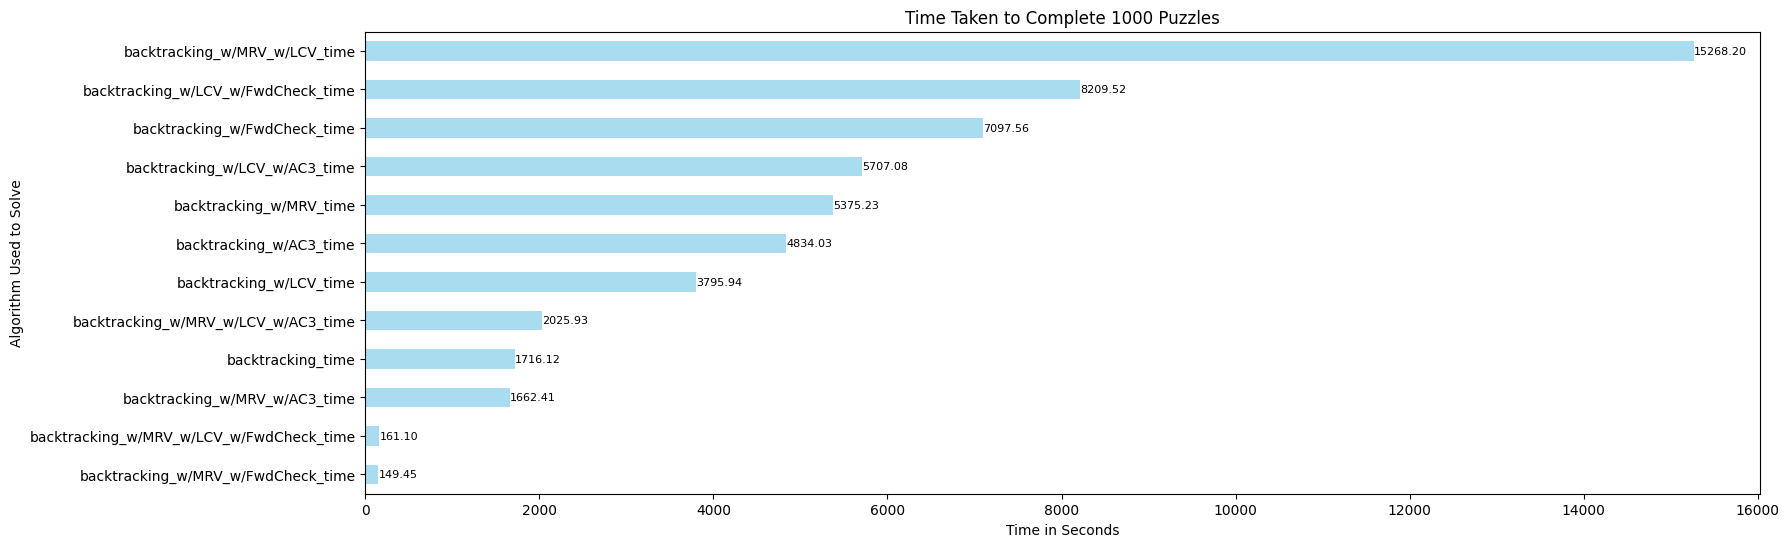

In [60]:
import matplotlib.pyplot as plt
columns_to_drop_numBacktrac = ["id","puzzle","solution","clues","difficulty","backtracking_w/MRV_w/LCV_w/AC3_numBacktracks",
                               "backtracking_w/MRV_w/LCV_w/FwdCheck_numBacktracks","backtracking_w/MRV_w/LCV_numBacktracks",
                               "backtracking_w/MRV_numBacktracks","backtracking_numBacktracks","backtracking_w/LCV_numBacktracks",
                              "backtracking_w/LCV_w/FwdCheck_numBacktracks","backtracking_w/LCV_w/AC3_numBacktracks","backtracking_w/AC3_numBacktracks",
                              "backtracking_w/FwdCheck_numBacktracks","backtracking_w/MRV_w/AC3_numBacktracks","backtracking_w/MRV_w/FwdCheck_numBacktracks"]

new_df_times = df.drop(columns = columns_to_drop_numBacktrac)
cumulative_time = new_df_times.sum()
cumulative_time = cumulative_time.sort_values()
plt.figure(figsize=(18, 6))
ax = cumulative_time.plot(kind='barh', color='skyblue', alpha=0.7)
for index, value in enumerate(cumulative_time):
    ax.text(value, index, f'{value:.2f}', ha='left', va='center', fontsize = 8)

plt.xlabel('Time in Seconds')
plt.ylabel('Algorithm Used to Solve')
plt.title('Time Taken to Complete 1000 Puzzles')
plt.show()

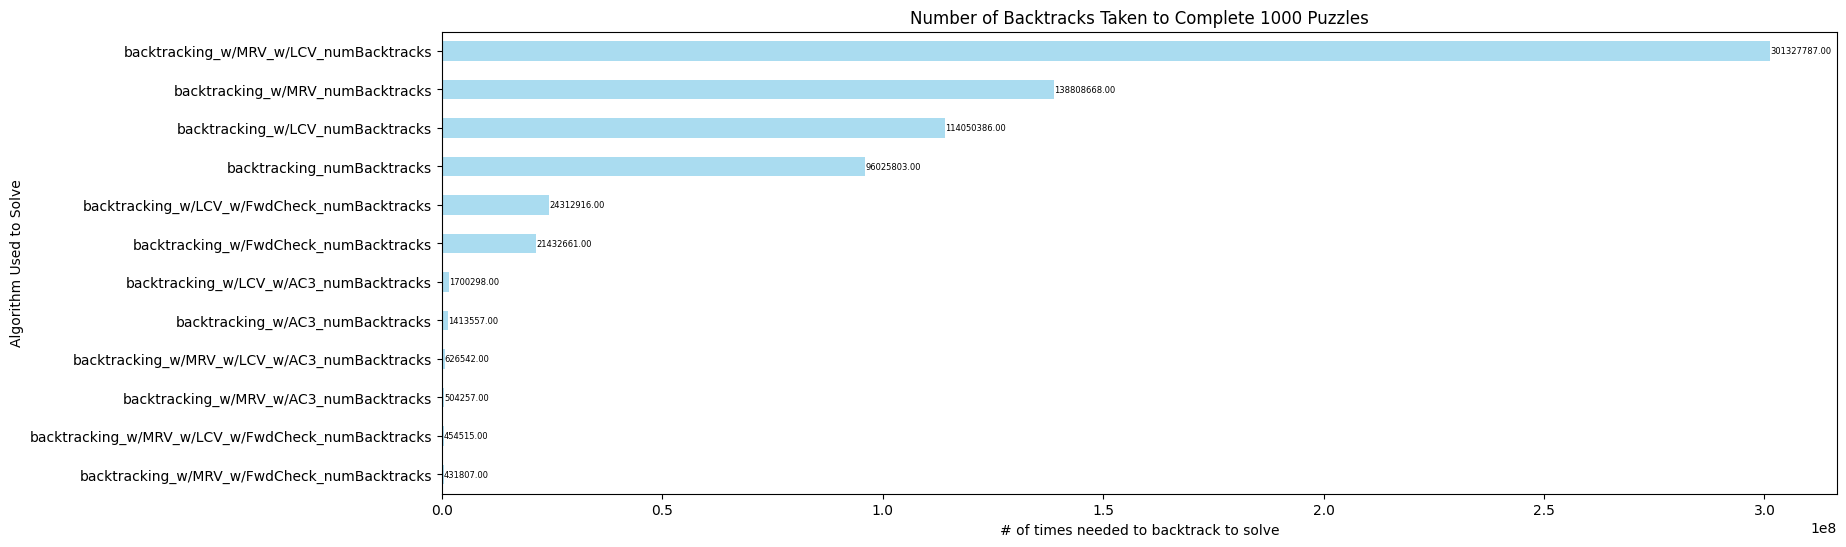

In [63]:
columns_to_drop_time = ["id","puzzle","solution","clues","difficulty", "backtracking_w/MRV_w/LCV_w/AC3_time","backtracking_w/MRV_w/LCV_w/FwdCheck_time","backtracking_w/MRV_w/LCV_time",
                        "backtracking_w/MRV_time","backtracking_time","backtracking_w/LCV_time","backtracking_w/LCV_w/FwdCheck_time","backtracking_w/LCV_w/AC3_time","backtracking_w/AC3_time",
                       "backtracking_w/FwdCheck_time","backtracking_w/MRV_w/AC3_time","backtracking_w/MRV_w/FwdCheck_time"]
new_df_numBactrac = df.drop(columns = columns_to_drop_time)
cumulative_numBactrac = new_df_numBactrac.sum()
cumulative_numBactrac = cumulative_numBactrac.sort_values()
plt.figure(figsize=(18, 6))
ax = cumulative_numBactrac.plot(kind='barh', color='skyblue', alpha=0.7)
for index, value in enumerate(cumulative_numBactrac):
    ax.text(value, index, f'{value:.2f}', ha='left', va='center', fontsize = 6)

plt.xlabel('# of times needed to backtrack to solve')
plt.ylabel('Algorithm Used to Solve')
plt.title('Number of Backtracks Taken to Complete 1000 Puzzles')
plt.show()